# IMPORTING LIBRARIES

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats


# COMPARING STATISTICAL SIGNIFICANCE OF ACCURACIES FROM DIFFERENT MODELS

In [2]:
# Loading the accuracy values of repeated 10-fold cross validation
cv_accuracies_allchans  = pd.read_excel('CV_Accuracies_Multiple_Reps_AllChannels.xlsx').to_numpy()
cv_accuracies_nochan112 = pd.read_excel('CV_Accuracies_Multiple_Reps_NoChan112.xlsx').to_numpy()
cv_accuracies_handknob  = pd.read_excel('CV_Accuracies_Multiple_Reps_Handknob.xlsx').to_numpy()

# Computing the mean of each fold across the 20 repetitions of 10-fold cross validation.
cv_mean_acc_allchans  = cv_accuracies_allchans.mean(axis=0)
cv_mean_acc_nochan112 = cv_accuracies_nochan112.mean(axis=0)
cv_mean_acc_handknob  = cv_accuracies_handknob.mean(axis=0)


# PLOTTING DISTRIBUTIONS OF PER-FOLD MEANS ACROSS CHANNEL CONDITIONS

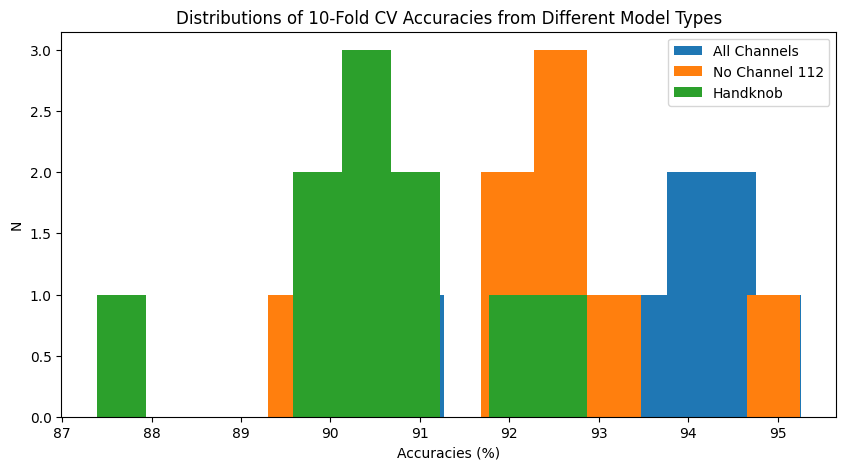

In [3]:
fig = plt.figure(figsize=(10,5))
plt.hist(cv_mean_acc_allchans)
plt.hist(cv_mean_acc_nochan112)
plt.hist(cv_mean_acc_handknob)
plt.legend(['All Channels','No Channel 112','Handknob'])
plt.title('Distributions of 10-Fold CV Accuracies from Different Model Types')
plt.xlabel('Accuracies (%)')
plt.ylabel('N');

# COMPUTING P-VALUE OF THE PER-FOLD MEANS ACROSS ALL CHANNEL CONDITIONS

In [4]:
# Ccomputing P-values
w_allchans_vs_nochan112, p_allchans_vs_nochan112 = scipy.stats.ranksums(cv_mean_acc_allchans, cv_mean_acc_nochan112)
w_allchans_vs_handknob, p_allchans_vs_handknob  = scipy.stats.ranksums(cv_mean_acc_allchans, cv_mean_acc_handknob)
w_nochan112_vs_handknob, p_nochan112_vs_handknob = scipy.stats.ranksums(cv_mean_acc_nochan112, cv_mean_acc_handknob)

# Holm-Bonferroni Correction. 
p_allchans_vs_handknob *= 3
p_allchans_vs_nochan112 *= 2
p_nochan112_vs_handknob *= 1

print('P-Value AllChans vs. NoChan112:', p_allchans_vs_nochan112)
print('P-Value AllChans vs. Handknob:', p_allchans_vs_handknob)
print('P-Value NoChan112 vs. Handknob:', p_nochan112_vs_handknob)

print('W-Statistic AllChans vs. NoChan112:', w_allchans_vs_nochan112)
print('W-Statistic AllChans vs. Handknob:', w_allchans_vs_handknob)
print('W-Statistic NoChan112 vs. Handknob:', w_nochan112_vs_handknob)


P-Value AllChans vs. NoChan112: 0.13928480959665626
P-Value AllChans vs. Handknob: 0.015476872712163928
P-Value NoChan112 vs. Handknob: 0.15092695006671628
W-Statistic AllChans vs. NoChan112: 1.8142294704442907
W-Statistic AllChans vs. Handknob: 2.7969371002682815
W-Statistic NoChan112 vs. Handknob: 1.4362649974350634


# PLOTTING BOX-PLOTS

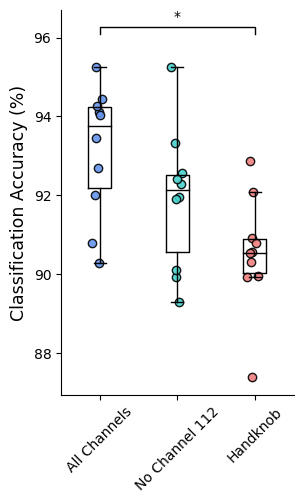

In [5]:

# Creating dataframe from combination of all per-fold means across all channel conditions.
dataset = np.concatenate((np.expand_dims(cv_mean_acc_allchans, axis=1), np.expand_dims(cv_mean_acc_nochan112, axis=1)), axis=1)
dataset = np.concatenate((dataset, np.expand_dims(cv_mean_acc_handknob, axis=1)), axis=1)
df = pd.DataFrame(dataset, columns=['All Channels','No Channel 112','Handknob'])
df.head()

# Adding jitter to location of scatter points on box-plots.
var = 0.04
vals, names, xs = [],[],[]
for i, col in enumerate(df.columns):
    vals.append(df[col].values)
    names.append(col)
    xs.append(np.random.normal(i + 1-var/2, var, df[col].values.shape[0]))  # adds jitter to the data points - can be adjusted

# Plotting the box-plots.
fig, ax = plt.subplots(figsize=(3,5))
medianprops = dict(color='black')
ax.boxplot(vals, labels=names, medianprops=medianprops, showfliers=False)
palette = ['cornflowerblue', 'mediumturquoise', 'lightcoral']
for x, val, c in zip(xs, vals, palette):
    ax.scatter(x, val, alpha=0.9, color=c, edgecolor = 'k')
ax.set_ylabel('Classification Accuracy (%)', fontsize = 12.5)
ax.spines[['right', 'top']].set_visible(False)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45);

# Significance bars
x1 = 1
x2 = 3
bottom, top = ax.get_ylim()
y_range = top - bottom
level = 1
bar_height = (y_range * 0.07 * level) + top
bar_tips = bar_height - (y_range * 0.02)
    
ax.plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
    )
p = p_allchans_vs_handknob
if p < 0.001:
    sig_symbol = '***'
elif p < 0.01:
    sig_symbol = '**'
elif p < 0.05:
    sig_symbol = '*'
text_height = bar_height + (y_range * 0.01)
ax.text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k');
